# Setup

In [ ]:
## Importação das bibliotecas nescessárias

# Manipulação dos dados
import pandas as pd
import numpy as np

# Visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Normalização
from sklearn.preprocessing import StandardScaler

# Analisar Clusters
from yellowbrick.cluster import kelbow_visualizer
from sklearn.neighbors import NearestNeighbors

# Modelos
from sklearn.cluster import KMeans, DBSCAN

# Metricas
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Configura Pandas para exibir valores em notação padrão com duas casas decimais
pd.options.display.float_format = '{:.2f}'.format

# Análise exploratória dos dados

## Carregando a base de dados

A base de dados será carregada utilizando a biblioteca Pandas e será armazenada em uma variável do tipo DataFrame, chamada `df`.

In [ ]:
# Carregando a base de dados a partir de um arquivo CSV
# Utilizando a codificação 'iso-8859-1' para garantir a correta leitura dos caracteres
df = pd.read_csv('data.csv', encoding='iso-8859-1')

# Exibindo as primeiras linhas do DataFrame para uma visualização inicial dos dados
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


In [ ]:
# Verificando os tipos de dados e a estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Para dar continuidade às análises, os tipos de dados serão ajustados para formatos mais adequados, levando em consideração suas estruturas e funcionalidades dentro do DataFrame.

In [ ]:
## Alterando os tipos dos dados para os tipos corretos

# Convertendo a coluna 'InvoiceDate' de tipo 'object' para 'datetime64[ns]'
# O parâmetro 'errors="coerce"' garante que qualquer valor inválido seja convertido para NaT (Not a Time)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Convertendo a coluna 'CustomerID' de tipo 'float64' para 'object'
# Utilizando uma função lambda para manter os valores nulos inalterados
# A conversão para string (str(int(x))) remove a parte decimal (.0) dos IDs
df['CustomerID'] = df['CustomerID'].apply(lambda x: str(int(x)) if pd.notna(x) else x)

In [ ]:
# Verificando se as alterações nos tipos de dados foram aplicadas corretamente
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,object
Country,object


Com os tipos de dados adequados, podemos prosseguir com a análise exploratória dos dados.

## Descrição estatística dos dados

In [ ]:
# Realizando uma descrição inicial dos dados no DataFrame
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.00,541909,541909.00
mean,9.55,2011-07-04 13:34:57.156386048,4.61
min,-80995.00,2010-12-01 08:26:00,-11062.06
25%,1.00,2011-03-28 11:34:00,1.25
50%,3.00,2011-07-19 17:17:00,2.08
75%,10.00,2011-10-19 11:27:00,4.13
max,80995.00,2011-12-09 12:50:00,38970.00
std,218.08,NaN,96.76


Nas primeiras análises, observamos que a quantidade e os preços unitários apresentam valores negativos, o que pode indicar que se tratam de produtos devolvidos. Contudo, é importante ressaltar que um produto não pode ter um valor inferior a zero.

Podemos notar também uma grande variabilidade nos dados, indicando uma significativa dispersão. Isso pode ser atribuído à baixa frequência de compras que apresentam valores e quantidades muito acima do padrão das transações mais comuns.

In [ ]:
# Verificando a presença de dados nulos no DataFrame
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Devido à impossibilidade de identificar clientes com IDs nulos, esses registros serão removidos da análise, pois não são relevantes para as operações da empresa. Além disso, as descrições nulas serão substituídas pela descrição do produto mais comprado.

In [ ]:
# Verificando a presença de dados duplicados no DataFrame
df.duplicated().sum()

5268

Os dados duplicados serão removidos da análise, uma vez que não é possível ter dois registros idênticos de compras. Caso um cliente adquira o mesmo produto ao mesmo tempo, a quantidade desse produto seria simplesmente incrementada em um único registro.

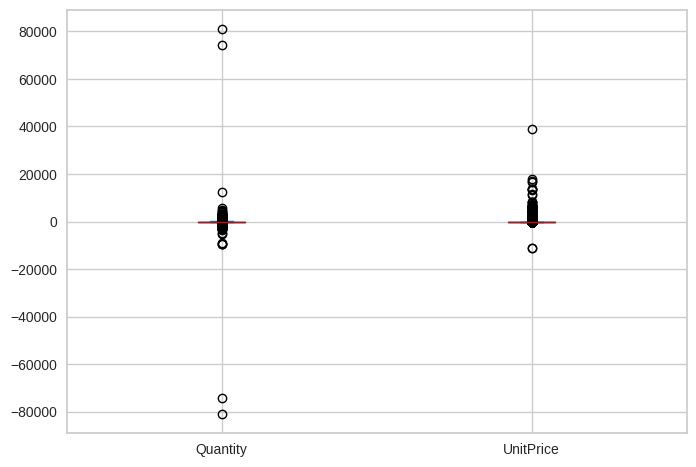

In [ ]:
# Gerando um gráfico de caixa para identificar possíveis outliers nas colunas numéricas do DataFrame
df.plot.box(grid=True);

Devido à alta variação nos dados observada no gráfico, os outliers serão removidos em etapas posteriores da análise. Essa decisão é baseada no fato de que houve poucas compras com quantidades elevadas ou produtos de valor elevado

## Análises sobre valores negativos estranhos

In [ ]:
# Analisando registros em que a coluna 'Quantity' é menor que zero
df.query('Quantity < 0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


Através da análise de alguns valores, como o desconto (Discount), podemos confirmar que esses registros representam efetivamente valores deduzidos das contas da empresa. Para fins de análise dos clientes, utilizaremos futuramente apenas os casos de devolução.

In [ ]:
# Analisando registros em que a coluna 'UnitPrice' é menor que zero
df.query('UnitPrice < 0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Os valores negativos na coluna 'UnitPrice' referem-se a ajustes de dívidas inadimplentes. Como esses valores representam uma dedução do caixa da empresa e não são úteis para a análise dos perfis dos clientes — sendo registros provenientes de um cliente que não pôde ser identificado —, esses dados serão removidos em etapas posteriores da análise.

## Visualização das distribuições

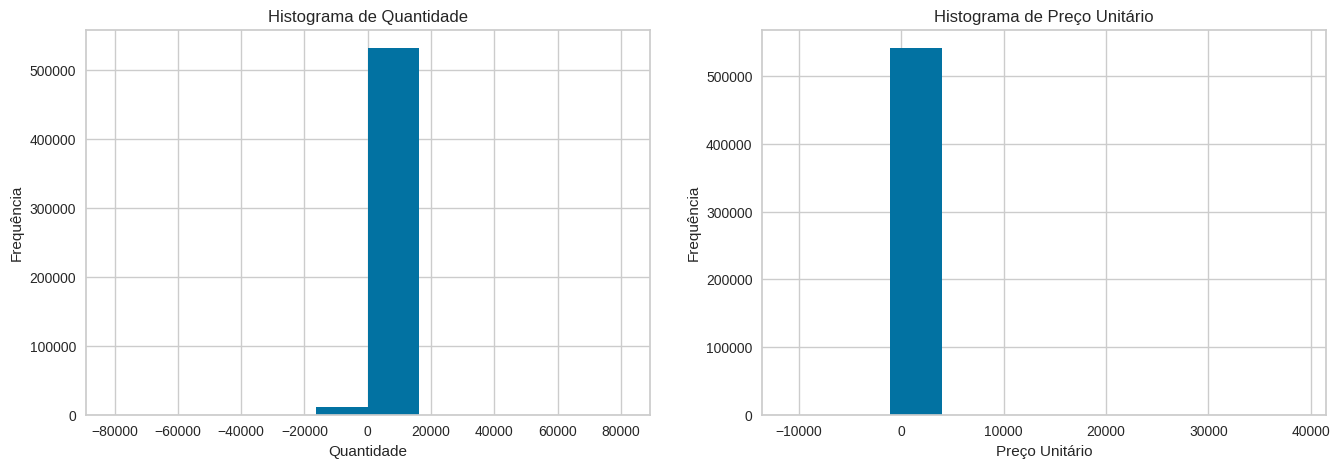

In [ ]:
# Ajustando as configurações do gráfico
# Criando uma figura com dois subgráficos lado a lado
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Criando o histograma da coluna 'Quantity'
df['Quantity'].plot.hist(ax=ax[0])

ax[0].set_title('Histograma de Quantidade') # Definindo o título do gráfico
ax[0].set_xlabel('Quantidade')              # Definindo o rótulo do eixo X
ax[0].set_ylabel('Frequência')              # Definindo o rótulo do eixo Y

# Criando o histograma da coluna 'UnitPrice'
df['UnitPrice'].plot.hist(ax=ax[1])

ax[1].set_title('Histograma de Preço Unitário') # Definindo o título do gráfico
ax[1].set_xlabel('Preço Unitário')              # Definindo o rótulo do eixo X
ax[1].set_ylabel('Frequência')                  # Definindo o rótulo do eixo Y

# Exibindo os gráficos
plt.show()

A maior parte dos dados está concentrada em um intervalo específico. Após a limpeza, esperamos poder visualizar esses dados de maneira mais clara e eficaz.

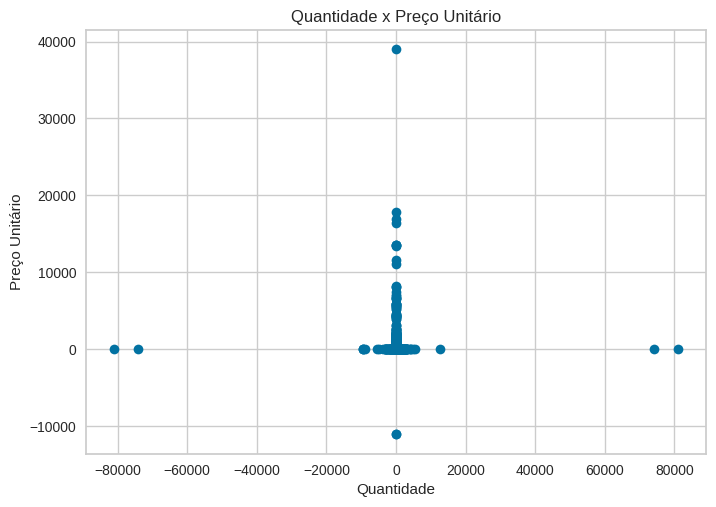

In [ ]:
# Gerando um gráfico de dispersão para visualizar a relação entre 'Quantity' e 'UnitPrice'
plt.plot('Quantity', 'UnitPrice', data=df, linestyle='none', marker='o')

plt.title('Quantidade x Preço Unitário') # Definindo o título do gráfico
plt.xlabel('Quantidade')                 # Definindo o rótulo do eixo X
plt.ylabel('Preço Unitário')             # Definindo o rótulo do eixo Y

# Exibindo o gráfico
plt.show()

Ao visualizar o gráfico de dispersão, observamos que, semelhante ao gráfico de caixa analisado anteriormente, a maioria dos dados se concentra em um ponto central, com apenas alguns registros dispersos ao redor. Isso indica que existem poucas compras com valores e quantidades significativamente elevados.

In [ ]:
# Agrupando os valores pela descrição dos produtos e somando as quantidades vendidas
qtd_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).reset_index()

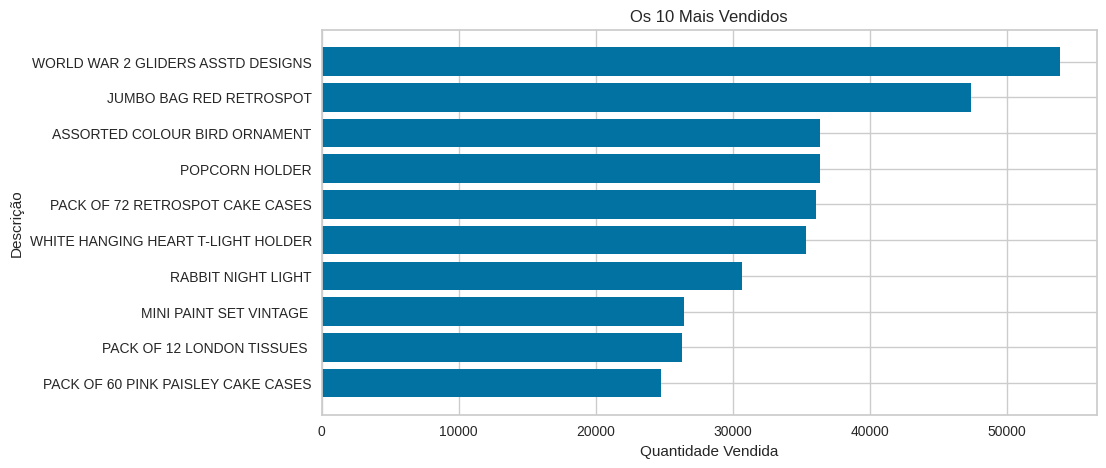

In [ ]:
## Criando um gráfico de barras horizontais para visualizar os 10 produtos mais vendidos
# A figura é configurada com um tamanho de 10x5 polegadas
fig = plt.figure(figsize=(10, 5))

# Usando 'barh()' para criar o gráfico de barras horizontais
plt.barh(qtd_products['Description'][0:10][::-1], qtd_products['Quantity'][0:10][::-1])

plt.title('Os 10 Mais Vendidos') # Definindo o título do gráfico
plt.xlabel('Quantidade Vendida') # Definindo o rótulo do eixo X
plt.ylabel('Descrição')          # Definindo o rótulo do eixo Y

# Exibindo o gráfico
plt.show()


In [ ]:
# Alterando a ordem do DataFrame 'qtd_products' para que as quantidades fiquem em ordem crescente
qtd_products.sort_values(by='Quantity', inplace=True)

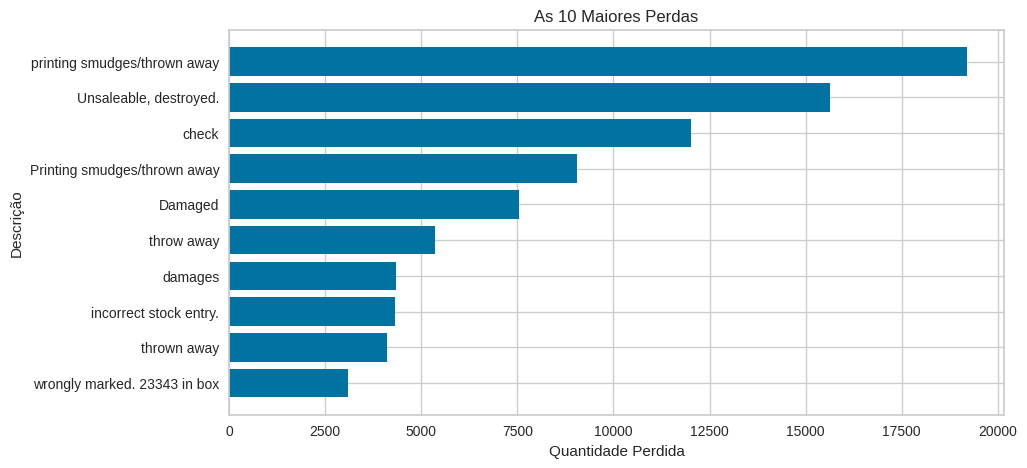

In [ ]:
## Criando um gráfico de barras horizontais para visualizar as 10 maiores perdas
# A figura é configurada com um tamanho de 10x5 polegadas
fig = plt.figure(figsize=(10, 5))

# Usando 'barh()' para criar o gráfico de barras horizontais
plt.barh(qtd_products['Description'][0:10][::-1], qtd_products['Quantity'][0:10][::-1] * (-1))

plt.title('As 10 Maiores Perdas') # Definindo o título do gráfico
plt.xlabel('Quantidade Perdida')  # Definindo o rótulo do eixo X
plt.ylabel('Descrição')           # Definindo o rótulo do eixo Y

# Exibindo o gráfico
plt.show()

Neste gráfico, podemos observar que existem descrições idênticas. É possível que haja mais valores semelhantes, com diferenças apenas nas letras. Como os produtos vendidos apresentam a descrição em letras maiúsculas como padrão, decidiremos utilizar apenas os dados com descrições em caixa alta nas análises futuras.

In [ ]:
# Agrupando os dados pela descrição dos produtos e calculando o valor médio dos preços unitários
valor_produtos = df.groupby('Description')['UnitPrice'].mean().sort_values(ascending=False).reset_index()

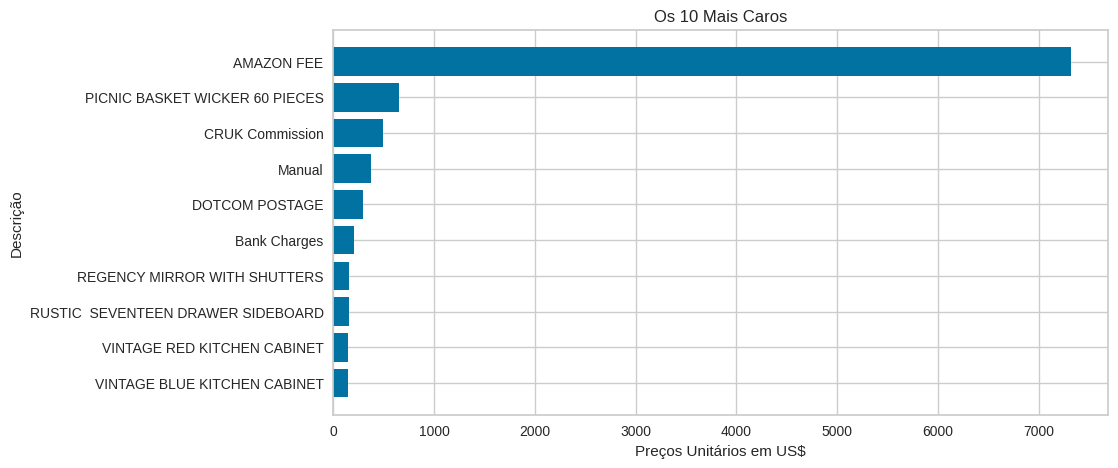

In [ ]:
# Criando um gráfico de barras horizontais para visualizar os 10 produtos mais caros
# A figura é configurada com um tamanho de 10x5 polegadas
fig = plt.figure(figsize=(10, 5))

# Usando 'barh()' para criar o gráfico de barras horizontais
plt.barh(valor_produtos['Description'][0:10][::-1], valor_produtos['UnitPrice'][0:10][::-1])

plt.title('Os 10 Mais Caros')         # Definindo o título do gráfico
plt.xlabel('Preços Unitários em US$') # Definindo o rótulo do eixo X
plt.ylabel('Descrição')               # Definindo o rótulo do eixo Y

# Exibindo o gráfico
plt.show()

In [ ]:
# Ordenando o DataFrame 'valor_produtos' em ordem crescente com base no preço unitário ('UnitPrice')
valor_produtos.sort_values(by='UnitPrice', inplace=True)

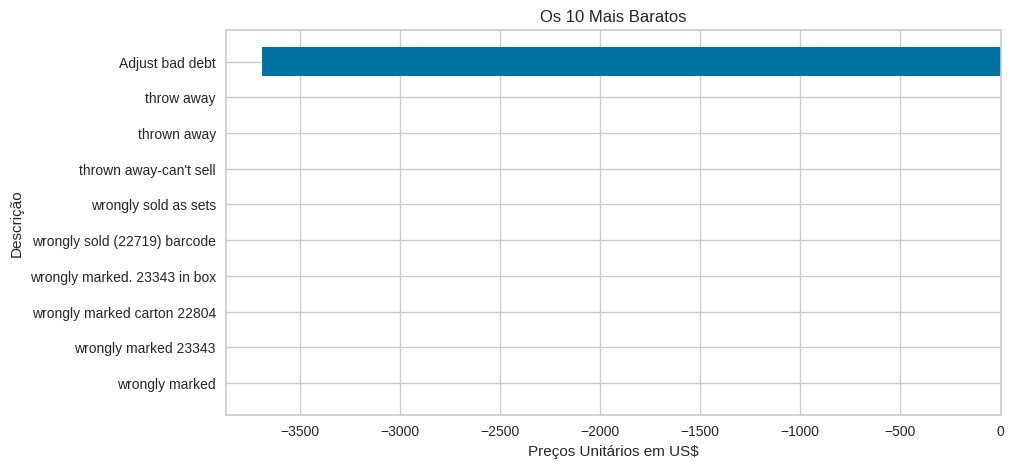

In [ ]:
# Criando um gráfico de barras horizontais para visualizar os 10 produtos mais baratos
# A figura é configurada com um tamanho de 10x5 polegadas
fig = plt.figure(figsize=(10, 5))

# Usando 'barh()' para criar o gráfico de barras horizontais
plt.barh(valor_produtos['Description'][0:10][::-1], valor_produtos['UnitPrice'][0:10][::-1])

plt.title('Os 10 Mais Baratos')       # Definindo o título do gráfico
plt.xlabel('Preços Unitários em US$') # Definindo o rótulo do eixo X
plt.ylabel('Descrição')               # Definindo o rótulo do eixo Y

# Exibindo o gráfico
plt.show()

De acordo com os gráficos, a maioria dos dados que apresentam valores estranhos ou inconsistentes está relacionada a situações que, em grande parte, resultaram em perdas para a empresa. Conforme discutido anteriormente e seguindo nossa proposta de focar na análise dos clientes, esses dados específicos não serão considerados em análises futuras.

Para removê-los, vamos filtrar os dados com base no padrão observado anteriormente, onde os nomes dos produtos estão em caixa alta.

#  Pré-processamento dos dados

## Limpeza dos dados

Agora, vamos proceder com a limpeza dos dados para possibilitar análises mais precisas e confiáveis.

In [ ]:
# Removendo registros duplicados do DataFrame
df.drop_duplicates(inplace=True)

In [ ]:
# Removendo registros com valores nulos na coluna 'CustomerID'
df.dropna(subset='CustomerID', inplace=True)

In [ ]:
# Contando o número de valores nulos na coluna 'Description'
df['Description'].isna().sum()

0

Como os registros com valores nulos na coluna 'Description' também tinham valores ausentes em 'CustomerID', eles foram removidos. Dessa forma, não foi necessário realizar outras alterações na coluna 'Description'.

Para prosseguirmos, realizaremos uma filtragem concentrada apenas nos registros de compras dos clientes, que será armazenada em um novo DataFrame chamado `df_sales`.

In [ ]:
# Filtrando o DataFrame 'df' para incluir apenas os registros onde a coluna 'Description' está em caixa alta
# Os registros filtrados são armazenados em um novo DataFrame chamado 'df_sales'
df_sales = df[df['Description'].str.isupper()]

In [ ]:
# Gerando estatísticas descritivas do DataFrame 'df_sales'
df_sales.describe()

,Quantity,InvoiceDate,UnitPrice
count,399660.00,399660,399660.00
mean,12.17,2011-07-10 11:15:36.938147584,3.06
min,-80995.00,2010-12-01 08:26:00,0.00
25%,2.00,2011-04-06 14:53:00,1.25
50%,5.00,2011-07-29 15:02:00,1.95
75%,12.00,2011-10-20 11:51:00,3.75
max,80995.00,2011-12-09 12:50:00,8142.75
std,250.75,NaN,19.77


## Transformando DataFrame

Vamos adicionar uma coluna chamada 'TotalPrice' no DataFrame `df_sales`, para calcular o valor total de cada transação. Dessa forma, poderemos entender melhor quanto cada cliente já gastou no e-commerce.

In [ ]:
# Calculando o valor total de cada transação e criando uma nova coluna 'TotalPrice' no DataFrame 'df_sales'
# A coluna 'TotalPrice' é o resultado da multiplicação da 'Quantity' (quantidade comprada) pelo 'UnitPrice' (preço unitário)
df_sales['TotalPrice'] = df_sales['Quantity'] * df_sales['UnitPrice']

# Exibindo as primeiras linhas do DataFrame atualizado para verificar a nova coluna 'TotalPrice'
df_sales.head()

<ipython-input-27-5eab79392d42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['TotalPrice'] = df_sales['Quantity'] * df_sales['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


Agora, criaremos um terceiro DataFrame que agrupará as compras dos clientes por produto. Esse agrupamento nos permitirá identificar devoluções ou cancelamentos, além de situações em que os clientes devolveram apenas parte dos produtos adquiridos. Também será útil para analisar registros com erros ou devoluções de produtos possivelmente comprados antes da data de corte dos dados.

O DataFrame `df_customer` será composto por seis colunas:

- CustomerID: O ID dos clientes agrupados.
- Description: Os produtos agrupados.
- Quantity: A quantidade total que o cliente possui de cada produto após todas as compras e devoluções realizadas no e-commerce.
- TotalPriceAverage: A média dos valores totais pagos pelo cliente por cada produto.
- LastDate: A última data em que o cliente comprou ou devolveu aquele produto.
- FrequencyBuy: A frequência de compras do cliente sobre aquele produto.
- FrequencyDevolution: A frequência de devoluções ou cancelamentos do cliente sobre aquele produto.
  
Além disso, após os agrupamentos, será criada uma última coluna chamada 'EffectiveFrequency', que representará a diferença entre a quantidade de compras e devoluções/cancelamentos do cliente para cada produto, dessa forma teremos os valores correspondentes a clientes com frequências beneficas ao e-commerce, ou frequência voltadas a devolver ou cancelar pedidos.

In [ ]:
# Função para calcular a frequência de compras
def frequency_buy(indx):
    # Inicializa a variável 'positives' para contar as vendas com quantidade positiva
    positives = 0
    # Itera sobre cada elemento do índice 'indx'
    for x in indx:
        # Verifica se a quantidade de vendas no índice 'x' é maior que zero
        if df_sales['Quantity'][x] > 0:
            # Se for maior que zero, incrementa o contador 'positives'
            positives += 1

    # Retorna o total de vendas com quantidade positiva
    return positives

In [ ]:
# Função para calcular a frequência de cancelamentos ou devoluções
def frequency_devolution(values, indx):
    # Calcula e retorna a diferença entre a contagem total de frequência e a frequência de compras
    return values.count() - frequency_buy(indx)

In [ ]:
# Função para verificar o primeiro valor de compra, pois todos os valores de quantidade negativa anteriores, represetam cancelamentos, ou devoluções de produtos fora da data de corte
def of_the_first_positive(values, indx, aggregate):
    # Encontra o primeiro índice em 'indx' onde a quantidade em 'df_sales' é maior que 0
    first_positive_index = next((i for i in indx if df_sales['Quantity'][i] > 0), None)

    # Se não houver índices positivos, retorna 0
    if first_positive_index is None:
        return 0

    # Utiliza uma estrutura 'match' para determinar a operação a ser realizada (soma ou média)
    match aggregate:
        case 'sum':
            # Calcula e retorna a soma dos valores a partir do primeiro índice positivo até o final
            return np.sum(values[indx.get_loc(first_positive_index):])
        case 'mean':
            # Calcula e retorna a média dos valores a partir do primeiro índice positivo até o final
            return np.mean(values[indx.get_loc(first_positive_index):])


In [ ]:
# Agrupa o DataFrame 'df_sales' por 'CustomerID' e 'Description'
df_customer = (
    df_sales
    .groupby(['CustomerID', 'Description'])
    .agg(
        # Calcula a quantidade total a partir do primeiro índice positivo usando a função 'of_the_first_positive'
        Quantity=('Quantity', lambda x: of_the_first_positive(x, x.index, 'sum')),

        # Calcula a média do preço total a partir do primeiro índice positivo usando a função 'of_the_first_positive'
        TotalPriceAverage=('TotalPrice', lambda x: of_the_first_positive(x, x.index, 'mean')),

        # Obtém a última data de compra do cliente
        LastDate=('InvoiceDate', 'max'),

        # Calcula a frequência de compras usando a função 'frequency_buy'
        FrequencyBuy=('Description', lambda x: frequency_buy(x.index)),

        # Calcula a frequência de devoluções usando a função 'frequency_devolution'
        FrequencyDevolution=('Description', lambda x: frequency_devolution(x, x.index))
    ).reset_index()  # Reseta o índice para que 'CustomerID' e 'Description' sejam colunas novamente
)

# Calcula a frequência efetiva como a diferença entre a frequência de compras e a frequência de devoluções
df_customer['EffectiveFrequency'] = df_customer['FrequencyBuy'] - df_customer['FrequencyDevolution']

Agora, vamos remover as quantidades menores ou iguais a zero, pois elas representam produtos em que o cliente devolveu todas as compras realizadas. Esses registros não fornecem informações úteis para nossa análise.

In [ ]:
# Filtra o DataFrame 'df_customer' para manter apenas as linhas onde a coluna 'Quantity' é maior que 0
df_customer.query('Quantity > 0', inplace=True)

# Exibe as primeiras linhas do DataFrame filtrado para verificar o resultado
df_customer.head()

,CustomerID,Description,Quantity,TotalPriceAverage,LastDate,FrequencyBuy,FrequencyDevolution,EffectiveFrequency
1,12347,3D DOG PICTURE PLAYING CARDS,126,74.34,2011-10-31 12:25:00,5,0,5
2,12347,3D SHEET OF CAT STICKERS,12,10.20,2011-04-07 10:43:00,1,0,1
3,12347,3D SHEET OF DOG STICKERS,12,10.20,2011-04-07 10:43:00,1,0,1
4,12347,60 TEATIME FAIRY CAKE CASES,72,13.20,2011-10-31 12:25:00,3,0,3
5,12347,72 SWEETHEART FAIRY CAKE CASES,72,13.20,2011-10-31 12:25:00,3,0,3


In [ ]:
# Gera estatísticas descritivas para as colunas numéricas do DataFrame 'df_customer'
df_customer.describe()

,Quantity,TotalPriceAverage,LastDate,FrequencyBuy,FrequencyDevolution,EffectiveFrequency
count,265609.00,265609.00,265609,265609.00,265609.00,265609.00
mean,18.39,18.05,2011-07-25 20:51:34.294846720,1.47,0.02,1.44
min,1.00,-1.10,2010-12-01 08:34:00,1.00,0.00,-6.00
25%,2.00,4.95,2011-04-26 14:47:00,1.00,0.00,1.00
50%,6.00,11.55,2011-08-28 11:25:00,1.00,0.00,1.00
75%,12.00,17.88,2011-11-01 15:49:00,1.00,0.00,1.00
max,12540.00,19809.75,2011-12-09 12:50:00,84.00,10.00,83.00
std,92.93,63.33,NaN,1.35,0.18,1.33


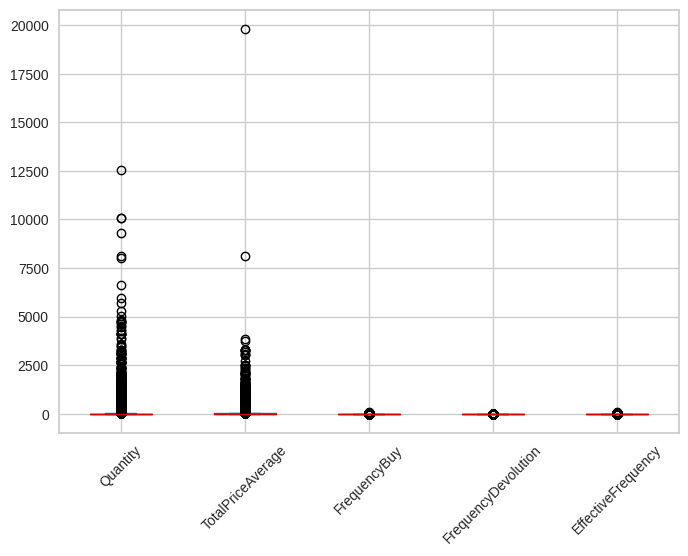

In [ ]:
# Plota o boxplot e armazena o objeto de eixos
ax = df_customer.plot.box()

# Rotaciona os rótulos do eixo x em 90 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Ao analisar o DataFrame `df_customer`, observamos que a coluna 'TotalPriceAverage' apresentam valores que se desviam significativamente da média, semelhantes aos valores encontrados no DataFrame `df`. Para garantir que o DataFrame contenha dados mais precisos e representativos para os clientes, procederemos à remoção dos outliers.

Para remover os outliers, utilizaremos o método do intervalo interquartil (IQR). Esse método envolve calcular o primeiro quartil (Q1) e o terceiro quartil (Q3) das colunas de interesse e, em seguida, definir limites inferiores e superiores com base na diferença entre esses quartis. Valores que estiverem além desses limites serão considerados outliers e serão excluídos do DataFrame.

In [ ]:
# Função para calcular os limites para identificar outliers em uma coluna específica
def outilers(column, df, q = 1):
    # Calcula o primeiro quartil (Q1) da coluna especificada
    Q1 = df[column].quantile(0.25)
    # Calcula o terceiro quartil (Q3) da coluna especificada
    Q3 = df[column].quantile(0.75)
    # Calcula o intervalo interquartil (IQR)
    IQR = Q3 - Q1

    # Utiliza uma estrutura 'match' para determinar qual limite calcular (inferior ou superior)
    match q:
        case 1:
            # Retorna o limite inferior para identificar outliers
            return Q1 - IQR * 1.5
        case 3:
            # Retorna o limite superior para identificar outliers
            return Q3 + IQR * 1.5


In [ ]:
# Filtra o DataFrame 'df_customer' para remover outliers em múltiplas colunas
df_customer.query(
    # Condição para manter apenas as linhas onde 'Quantity' está dentro dos limites definidos pelos outliers
    f'(Quantity > {outilers("Quantity", df_customer)} and Quantity < {outilers("Quantity", df_customer, 3)}) '
    # Condição para manter apenas as linhas onde 'TotalPriceAverage' está dentro dos limites definidos pelos outliers
    f'and (TotalPriceAverage > {outilers("TotalPriceAverage", df_customer)} and TotalPriceAverage < {outilers("TotalPriceAverage", df_customer, 3)})',
    inplace=True # Aplica a filtragem diretamente ao DataFrame, modificando-o sem criar uma cópia
)

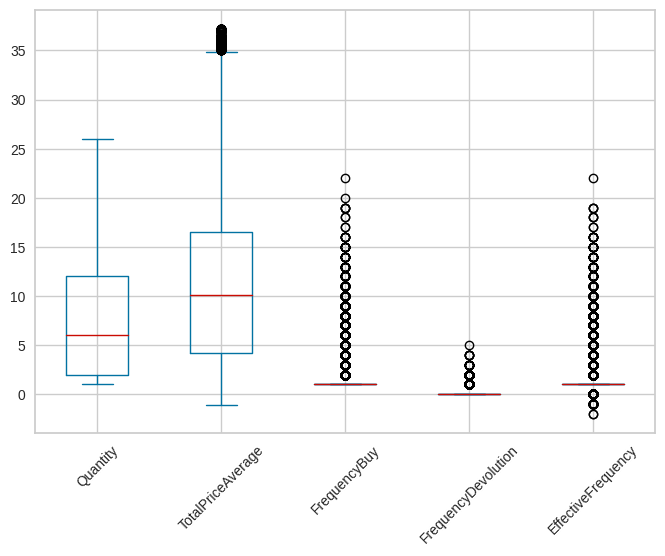

In [ ]:
# Plota o boxplot e armazena o objeto de eixos
ax = df_customer.plot.box()

# Rotaciona os rótulos do eixo x em 90 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

## Cálculo do RFM

Para dar continuidade à análise, utilizaremos o cálculo do RFM (Recency, Frequancy e Mean Ticket). Essa abordagem nos permitirá obter insights mais claros e significativos sobre o comportamento de cada cliente.

O RFM é uma metodologia amplamente utilizada para segmentar clientes com base em seu histórico de compras. Cada componente do RFM fornece informações valiosas:

- Recency (R): Mede o tempo desde a última compra do cliente. Clientes que compraram recentemente estão mais propensos a comprar novamente.
- Frequency (F): Avalia a regularidade das compras de um cliente. Clientes que compram com mais frequência têm maior probabilidade de serem leais à marca.
- Mean Ticket (M): Refere-se ao gasto médio pelo cliente em um determinado período. Clientes que gastam mais são considerados de maior valor..

Analisando esses três fatores, podemos identificar melhor os segmentos de clientes.

Para calcular o RFM, adotaremos a seguinte metodologia:

- Recency (R): Utilizaremos a data mais recente registrada na coluna 'LastDate', e transformaremos em dias de recência. Essa métrica nos permitirá entender quanto tempo se passou desde a última interação do cliente, o que é crucial para avaliar a probabilidade de recompra.

- Frequency (F): Calcularemos a soma das frequências na coluna 'EffectiveFrequency'. Esse valor refletirá não apenas as compras realizadas pelos clientes, mas também levará em consideração aquelas que resultaram em devoluções e cancelamentos. Assim, obteremos uma visão mais precisa da atividade do cliente e de seu valor para a empresa.

- Mean Ticket (M): Para essa métrica, utilizaremos a média da coluna 'TotalPriceAverage'. Isso nos permitirá avaliar o valor médio das transações realizadas pelos clientes, ajudando a entender melhor seu comportamento de compra.

In [ ]:
# A função recebe um DataFrame 'df' e uma data 'last_date' para calcular os valores RFM.
def calculate_rfm(df, last_date):

    # 'groupby' agrupa os dados por 'CustomerID', ou seja, cada cliente será agrupado em uma linha.
    df_rfm = df.groupby('CustomerID').agg(

        # 'Recency' é calculado subtraindo a última compra do cliente ('LastDate') da data mais recente (last_date).
        # O resultado é o número de dias desde a última compra.
        Recency=('LastDate', lambda x: (last_date - x.max()).days),

        # 'Frequency' é a soma do número de transações ou visitas do cliente, armazenadas na coluna 'EffectiveFrequency'.
        Frequency=('EffectiveFrequency', 'sum'),

        # 'MeanTicket' é a média dos valores de compras, calculada pela coluna 'TotalPriceAverage'.
        MeanTicket=('TotalPriceAverage', 'mean')
    )

    # A função retorna o DataFrame 'df_rfm' com os valores calculados para Recency, Frequency e MeanTicket.
    return df_rfm

# A variável 'last_date' captura a data mais recente de compra no DataFrame 'df_customer'.
last_date = df_customer['LastDate'].max()

# A função 'calculate_rfm' é chamada passando 'df_customer' e 'last_date' para gerar os valores de RFM para cada cliente.
df_rfm = calculate_rfm(df_customer, last_date)

# O DataFrame resultante 'df_rfm' contendo as métricas RFM é exibido.
df_rfm

,Recency,Frequency,MeanTicket
CustomerID,,,
12347,1,101,18.20
12348,248,2,18.70
12349,18,65,17.01
12350,309,16,18.40
12352,35,70,16.38
...,...,...,...
18280,277,10,18.06
18281,180,7,11.55
18282,7,11,14.92


In [ ]:
# Gera estatísticas descritivas para as colunas numéricas do DataFrame 'df_rfm'
df_rfm.describe()

,Recency,Frequency,MeanTicket
count,4133.00,4133.00,4133.00
mean,91.51,70.96,13.74
std,99.79,145.67,5.67
min,0.00,-2.00,0.77
25%,17.00,15.00,8.98
50%,50.00,35.00,15.17
75%,143.00,80.00,17.30
max,373.00,4118.00,36.00


## Normalizando os dados

In [ ]:
# Inicializa um objeto do tipo StandardScaler para normalizar ou padronizar as variáveis numéricas
scaler = StandardScaler()

In [ ]:
# Aplica o StandardScaler para normalizar as colunas do DataFrame 'df_rfm'
scaled_data = scaler.fit_transform(df_rfm)

# Cria um novo DataFrame com os dados normalizados, mantendo as colunas e índices originais
df_rfm_transformed = pd.DataFrame(
    data=scaled_data,           # Usa os dados escalados retornados pelo StandardScaler
    columns=df_rfm.columns,     # Mantém os nomes das colunas originais
    index=df_rfm.index          # Mantém os índices originais dos clientes
)

# Exibe as primeiras linhas do DataFrame normalizado para verificação
df_rfm_transformed.head()

,Recency,Frequency,MeanTicket
CustomerID,,,
12347,-0.91,0.21,0.79
12348,1.57,-0.47,0.88
12349,-0.74,-0.04,0.58
12350,2.18,-0.38,0.82
12352,-0.57,-0.01,0.47


In [ ]:
# Gera estatísticas descritivas para as colunas numéricas do DataFrame 'df_rfm_transformed'
df_rfm_transformed.describe()

,Recency,Frequency,MeanTicket
count,4133.00,4133.00,4133.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-0.92,-0.50,-2.29
25%,-0.75,-0.38,-0.84
50%,-0.42,-0.25,0.25
75%,0.52,0.06,0.63
max,2.82,27.79,3.93


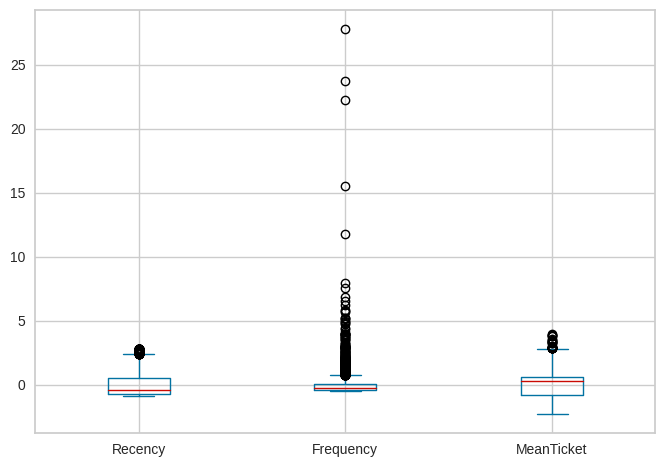

In [ ]:
# Cria um box plot (gráfico de caixa) para visualizar a distribuição das variáveis
df_rfm_transformed.plot.box();

Podemos observar que, mesmo após o cálculo do RFM e a normalização dos dados, ainda existem valores que se encontram significativamente acima da média. Esses valores representam outliers, que são clientes excepcionais com frequências de compra muito altas. Ao analisar o gráfico, fica claro que esses clientes não refletem o comportamento típico do nosso grupo de clientes. Para obter uma análise mais precisa e representativa, será necessário realizar uma nova limpeza para remover esses outliers. Isso nos permitirá focar em um conjunto de dados que melhor representa o comportamento geral dos clientes, facilitando assim a segmentação e a formulação de estratégias de marketing mais eficazes.

In [ ]:
# Filtra o DataFrame 'df_rfm_transformed' para remover outliers nas colunas 'Recency', 'Frequency' e 'MeanTicket'
df_rfm_transformed.query(
    # Condição para manter apenas as linhas onde 'Recency' está dentro dos limites definidos pelo intervalo interquartil
    f'(Recency > {outilers("Recency", df_rfm_transformed)} and Recency < {outilers("Recency", df_rfm_transformed, 3)}) '
    # Condição para manter apenas as linhas onde 'Frequency' está dentro dos limites definidos pelo intervalo interquartil
    f'and (Frequency > {outilers("Frequency", df_rfm_transformed)} and Frequency < {outilers("Frequency", df_rfm_transformed, 3)}) '
    # Condição para manter apenas as linhas onde 'MeanTicket' está dentro dos limites definidos pelo intervalo interquartil
    f'and (MeanTicket > {outilers("MeanTicket", df_rfm_transformed)} and MeanTicket < {outilers("MeanTicket", df_rfm_transformed, 3)})',
    inplace=True  # Aplica a filtragem diretamente ao DataFrame, removendo os outliers sem criar uma cópia
)


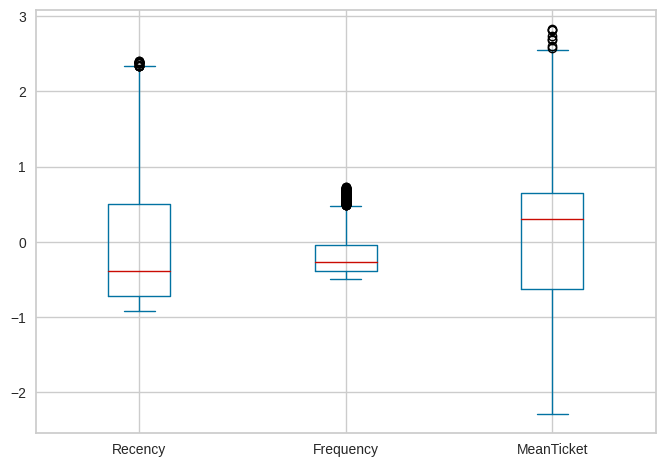

In [ ]:
# Cria um box plot (gráfico de caixa) para visualizar a distribuição das variáveis 'Recency', 'Frequency' e 'MeanTicket' no DataFrame df_rfm_transformed.
df_rfm_transformed.plot.box();

# Modelagem

Agora que temos nossos dados organizados em formato RFM e normalizados, podemos avançar para a etapa de criação do modelo de clusterização. O objetivo desta fase é identificar agrupamentos significativos entre os clientes, permitindo uma segmentação mais eficaz.

A clusterização é uma técnica de aprendizado não supervisionado que busca agrupar dados com características semelhantes. No contexto do RFM, isso nos ajuda a entender diferentes perfis de clientes com base em suas interações com a empresa.

## Selecione um algoritmo de clusterização

Vamos analisar dois algoritmos de clusterização, KMeans e DBSCAN, para definir o mais adequado aos nossos dados RFM. KMeans é eficiente para dividir os clientes em grupos claros e distintos, enquanto DBSCAN identifica padrões complexos e outliers sem a necessidade de definir o número de clusters.

### KMeans

Para determinar a quantidade ideal de clusters para o nosso modelo, utilizaremos os métodos do Elbow e Silhouette. Para facilitar o acesso a esses métodos, implementaremos a função `kelbow_visualizer` da biblioteca Yellowbrick. Essa abordagem nos permitirá visualizar de forma clara e intuitiva a relação entre o número de clusters e a performance do modelo, auxiliando na escolha do número mais adequado de clusters para a nossa análise.

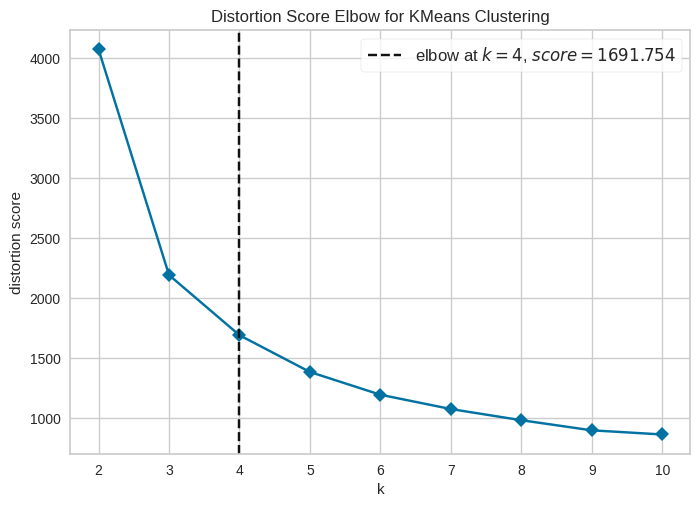

In [ ]:
# Visualizando a relação entre o número de clusters e a performance do modelo KMeans
# O primeiro gráfico utilizará o método do Elbow para determinar o número ideal de clusters
kelbow_visualizer(
    model=KMeans(random_state=2024),  # Inicializa o modelo KMeans com uma semente aleatória para reprodutibilidade
    X=df_rfm_transformed,              # DataFrame transformado que contém os dados de entrada para o modelo
    timings=False                      # Desativa a exibição dos tempos de execução
);

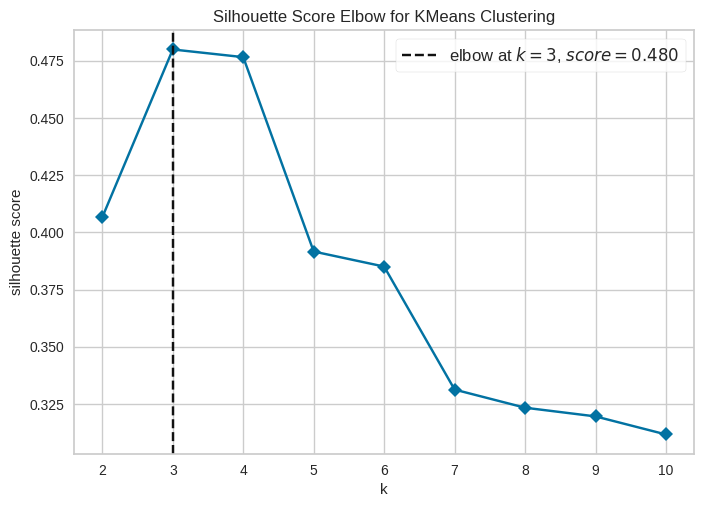

In [ ]:
# Visualizando a métrica Silhouette para a mesma análise
# O segundo gráfico avaliará a qualidade dos clusters com base na métrica de Silhouette
kelbow_visualizer(
    model=KMeans(random_state=2024),  # Novamente, inicializa o modelo dbscan com a mesma semente
    X=df_rfm_transformed,              # Usamos os mesmos dados de entrada
    timings=False,                     # Desativa a exibição dos tempos de execução
    metric='silhouette'                # Especifica que a métrica de avaliação a ser utilizada é a Silhouette
);

Agora que identificamos os melhores resultados de clusters para o nosso modelo, utilizaremos as métricas Silhouette Score, Calinski-Harabasz Score e Davies-Bouldin Score. Essas métricas nos proporcionarão uma terceira perspectiva sobre a qualidade dos clusters e permitirão avaliar de forma abrangente o desempenho do nosso modelo. Essa análise adicional nos ajudará a entender melhor como os dados estão agrupados e a confirmar a eficácia da nossa abordagem de clustering.

In [ ]:
# Criando um DataFrame vazio chamado df_kmeans para armazenar os resultados das métricas de avaliação dos clusters
df_kmeans = pd.DataFrame({
    'K': [],                             # Coluna 'K' para armazenar o número de clusters utilizados
    'Silhouette_Score': [],              # Coluna para armazenar o valor do Silhouette Score correspondente a cada número de clusters
    'Calinski_Harabas_Score': [],        # Coluna para armazenar o valor do Calinski-Harabasz Score para cada número de clusters
    'Davies_Bouldin_Score': []           # Coluna para armazenar o valor do Davies-Bouldin Score para cada número de clusters
})

# O DataFrame é inicializado com colunas definidas, mas sem dados, permitindo que os resultados sejam adicionados posteriormente

In [ ]:
# Iterando sobre um intervalo de valores para k, que representa o número de clusters
for k in range(3, 5):  # Neste caso, o loop será executado para k = 3 e k = 4
    # Inicializando o modelo KMeans com o número atual de clusters e uma semente aleatória para reprodutibilidade
    kmeans = KMeans(n_clusters=k, random_state=2024)

    # Ajustando o modelo aos dados e obtendo os rótulos dos clusters para cada ponto de dados
    kmeans_labels = kmeans.fit_predict(df_rfm_transformed)

    # Adicionando uma nova linha ao DataFrame df_kmeans com os resultados das métricas para o número atual de clusters
    df_kmeans.loc[len(df_kmeans)] = [
        k,  # Número de clusters
        silhouette_score(df_rfm_transformed, kmeans_labels),  # Calcula e adiciona o Silhouette Score
        calinski_harabasz_score(df_rfm_transformed, kmeans_labels),  # Calcula e adiciona o Calinski-Harabasz Score
        davies_bouldin_score(df_rfm_transformed, kmeans_labels)  # Calcula e adiciona o Davies-Bouldin Score
    ]

# Ao final do loop, df_kmeans conterá os valores das métricas de avaliação para k = 3 e k = 4

In [ ]:
# Aplicando gradientes de fundo ao DataFrame df_kmeans para destacar visualmente os valores das métricas de avaliação

df_kmeans.style.background_gradient(
    # Aplica um gradiente de fundo à coluna 'Silhouette_Score'
    subset=['Silhouette_Score'],              # Especifica que o gradiente deve ser aplicado apenas a essa coluna
    cmap='Blues',                             # Define o mapa de cores a ser utilizado (tons de azul)
    vmin=df_kmeans['Silhouette_Score'].min(),  # Define o valor mínimo para o gradiente (valor mais baixo da coluna)
    vmax=df_kmeans['Silhouette_Score'].max()   # Define o valor máximo para o gradiente (valor mais alto da coluna)
).background_gradient(
    # Aplica um gradiente de fundo à coluna 'Calinski_Harabas_Score'
    subset=['Calinski_Harabas_Score'],       # Especifica que o gradiente deve ser aplicado a esta coluna
    cmap='Blues',                             # Mantém o mesmo mapa de cores (tons de azul)
    vmin=df_kmeans['Calinski_Harabas_Score'].min(),  # Valor mínimo para o gradiente
    vmax=df_kmeans['Calinski_Harabas_Score'].max()   # Valor máximo para o gradiente
).background_gradient(
    # Aplica um gradiente de fundo à coluna 'Davies_Bouldin_Score'
    subset=['Davies_Bouldin_Score'],         # Especifica que o gradiente deve ser aplicado a esta coluna
    cmap='Blues_r',                           # Utiliza um mapa de cores reverso (tons de azul, do mais escuro para o mais claro)
    vmin=df_kmeans['Davies_Bouldin_Score'].min(),  # Valor mínimo para o gradiente
    vmax=df_kmeans['Davies_Bouldin_Score'].max()   # Valor máximo para o gradiente
)

,K,Silhouette_Score,Calinski_Harabas_Score,Davies_Bouldin_Score
0,3.000000,0.479894,3496.569995,0.739219
1,4.000000,0.476543,3379.715604,0.759185


Agora que analisamos as melhores métricas para o nosso modelo KMeans e obtivemos seus resultados, é hora de explorar outros métodos de clusterização. Essa comparação nos permitirá avaliar a eficácia de diferentes abordagens e identificar qual modelo se adapta melhor aos nossos dados. Ao considerar uma variedade de algoritmos, podemos aprimorar ainda mais nossa análise e obter insights mais robustos.

### DBSCAN

Para calcular o valor de eps no método DBSCAN, utilizaremos a função NearestNeighbors da biblioteca Scikit-Learn da seguinte maneira:

Primeiro, aplicamos o algoritmo dos k-vizinhos mais próximos aos nossos dados. Em seguida, geramos um gráfico que mostra as distâncias para os k-vizinhos mais próximos, ordenadas de forma crescente. O objetivo é identificar o ponto de inflexão no gráfico, conhecido como Elbow. Esse ponto representa a distância máxima que podemos considerar como pertencente a um cluster, ou seja, o valor apropriado para o parâmetro eps.

O parâmetro eps é crucial no algoritmo DBSCAN porque define o raio máximo em torno de um ponto que será considerado para determinar se outros pontos fazem parte do mesmo cluster. Valores muito pequenos para eps podem resultar em muitos pontos sendo considerados como ruído, enquanto valores muito grandes podem fazer com que clusters diferentes sejam agrupados como um único cluster. Assim, a escolha adequada de eps é essencial para garantir uma boa formação dos clusters.

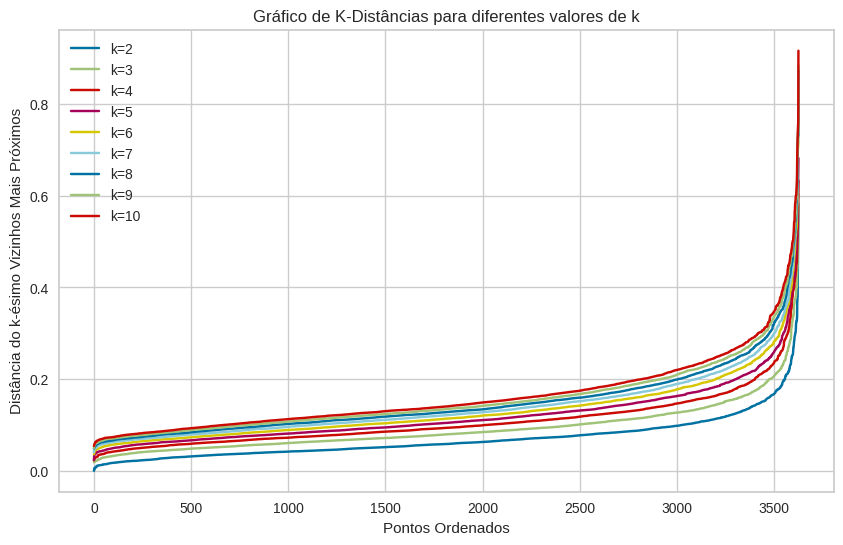

In [ ]:
# Criação de uma figura com tamanho 10x6
plt.figure(figsize=(10, 6))

# Loop para calcular as distâncias dos k-vizinhos mais próximos para k variando de 2 a 10
for k in range(2, 11):
    # Inicializa o modelo NearestNeighbors com k vizinhos
    neighbors = NearestNeighbors(n_neighbors=k)

    # Ajusta o modelo aos dados transformados do DataFrame RFM
    neighbors_fit = neighbors.fit(df_rfm_transformed)

    # Obtém as distâncias e índices dos k vizinhos mais próximos
    distances, indices = neighbors_fit.kneighbors(df_rfm_transformed)

    # Ordena as distâncias para o k-ésimo vizinho mais próximo de todos os pontos
    distances = np.sort(distances[:, k-1], axis=0)

    # Plota as distâncias para o valor atual de k, adicionando uma linha para cada valor de k
    plt.plot(distances, label=f'k={k}')

# Definir o título do gráfico
plt.title('Gráfico de K-Distâncias para diferentes valores de k')

# Definir o rótulo do eixo x
plt.xlabel('Pontos Ordenados')

# Definir o rótulo do eixo y
plt.ylabel('Distância do k-ésimo Vizinhos Mais Próximos')

# Habilitar a grade do gráfico
plt.grid(visible=True)

# Mostrar a legenda para identificar as curvas de cada valor de k
plt.legend()

# Mostrar o gráfico com todas as curvas de k
plt.show()

Baseado no gráfico de K-distâncias, podemos observar que o valor de eps provavelmente estará entre 0.1 e 0.3. Vamos, então, testar esses valores (eps = 0.1, eps = 0.2 e eps = 0.3) para verificar como eles impactam a qualidade dos clusters gerados pelo DBSCAN.

Para o parâmetro min_samples, utilizaremos os valores de k sugeridos pelo método `kelbowVisualizer` aplicado ao KMeans. A ideia por trás dessa abordagem é que o valor de k encontrado pelo `kelbow_visualizer` representa o número ideal de clusters no conjunto de dados, o que indica a quantidade de pontos necessários para formar uma estrutura densa. Portanto, podemos considerar esses valores de k como candidatos apropriados para o parâmetro min_samples no DBSCAN, que define quantos pontos vizinhos são necessários para que um ponto seja considerado parte de um cluster.

Dessa forma, ao testar diferentes combinações de eps e min_samples, baseados em um processo estruturado de análise dos dados, conseguimos obter uma avaliação mais precisa da eficácia do modelo DBSCAN, garantindo uma boa formação dos clusters e a correta identificação de ruído.

In [ ]:
# Criação de um DataFrame vazio chamado 'df_dbscan' para armazenar resultados de métricas do DBSCAN
df_dbscan = pd.DataFrame({
    'Eps': [],                        # Coluna 'Eps' para armazenar diferentes valores do parâmetro 'eps' do DBSCAN
    'Min_Samples': [],                # Coluna 'Min_Samples' para armazenar valores do parâmetro 'min_samples' do DBSCAN
    'Silhouette_Score': [],           # Coluna 'Silhouette_Score' para armazenar os valores do Silhouette Score para cada combinação de parâmetros
    'Calinski_Harabas_Score': [],     # Coluna 'Calinski_Harabas_Score' para armazenar os valores do índice Calinski-Harabasz para cada combinação
    'Davies_Bouldin_Score': []        # Coluna 'Davies_Bouldin_Score' para armazenar os valores do índice Davies-Bouldin para cada combinação
})

In [ ]:
# Loop para testar diferentes valores de 'eps' e 'min_samples' no DBSCAN
for ep in (.1, .2, .3):  # Itera sobre os valores de 'eps' (0.1, 0.2, 0.3)
    for min_sample in range(3, 5):  # Itera sobre os valores de 'min_samples' (3, 4)
        # Inicializa o modelo DBSCAN com os valores atuais de 'eps' e 'min_samples'
        dbscan = DBSCAN(eps=ep, min_samples=min_sample)

        # Ajusta o modelo aos dados e obtém os rótulos de cluster
        dbscan_labels = dbscan.fit_predict(df_rfm_transformed)

        # Adiciona uma nova linha ao DataFrame df_dbscan com os valores atuais de 'eps' e 'min_samples'
        # junto com os valores das métricas de avaliação
        df_dbscan.loc[len(df_dbscan)] = [
            ep,  # Valor de 'eps' utilizado
            min_sample,  # Valor de 'min_samples' utilizado
            silhouette_score(df_rfm_transformed, dbscan_labels),  # Cálculo do Silhouette Score
            calinski_harabasz_score(df_rfm_transformed, dbscan_labels),  # Cálculo do índice Calinski-Harabasz
            davies_bouldin_score(df_rfm_transformed, dbscan_labels)  # Cálculo do índice Davies-Bouldin
        ]

In [ ]:
# Aplicação de gradiente de cor ao DataFrame df_dbscan para facilitar a visualização dos resultados

df_dbscan.style.background_gradient(
    # Aplica um gradiente de fundo à coluna 'Silhouette_Score'
    subset=['Silhouette_Score'],              # Especifica que o gradiente deve ser aplicado apenas a essa coluna
    cmap='Blues',                             # Define o mapa de cores a ser utilizado (tons de azul)
    vmin=df_dbscan['Silhouette_Score'].min(),  # Define o valor mínimo para o gradiente (valor mais baixo da coluna)
    vmax=df_dbscan['Silhouette_Score'].max()   # Define o valor máximo para o gradiente (valor mais alto da coluna)
).background_gradient(
    # Aplica um gradiente de fundo à coluna 'Calinski_Harabas_Score'
    subset=['Calinski_Harabas_Score'],       # Especifica que o gradiente deve ser aplicado a esta coluna
    cmap='Blues',                             # Mantém o mesmo mapa de cores (tons de azul)
    vmin=df_dbscan['Calinski_Harabas_Score'].min(),  # Valor mínimo para o gradiente
    vmax=df_dbscan['Calinski_Harabas_Score'].max()   # Valor máximo para o gradiente
).background_gradient(
    # Aplica um gradiente de fundo à coluna 'Davies_Bouldin_Score'
    subset=['Davies_Bouldin_Score'],         # Especifica que o gradiente deve ser aplicado a esta coluna
    cmap='Blues_r',                           # Utiliza um mapa de cores reverso (tons de azul, do mais escuro para o mais claro)
    vmin=df_dbscan['Davies_Bouldin_Score'].min(),  # Valor mínimo para o gradiente
    vmax=df_dbscan['Davies_Bouldin_Score'].max()   # Valor máximo para o gradiente
)

,Eps,Min_Samples,Silhouette_Score,Calinski_Harabas_Score,Davies_Bouldin_Score
0,0.100000,3.000000,-0.364523,39.291212,1.282474
1,0.100000,4.000000,-0.369682,45.517842,1.303538
2,0.200000,3.000000,-0.222100,14.657520,1.469951
3,0.200000,4.000000,-0.170849,18.619604,1.334485
4,0.300000,3.000000,0.251210,9.935881,3.037533
5,0.300000,4.000000,0.301539,14.647821,3.268543


### Conclusão

Com base nos resultados, observamos que KMeans se destaca pela sua consistência na formação de clusters, apresentando métricas robustas e confiáveis. Seus valores de Silhouette Score e Calinski-Harabasz Score indicam agrupamentos bem definidos e coesos.

Em contraste, DBSCAN apresentou uma performance mais variável, sendo altamente sensível às definições dos parâmetros eps e min_samples, o que pode comprometer a qualidade dos clusters formados.

Diante disso, a escolha mais apropriada para a análise é o KMeans, que oferece uma segmentação clara e eficaz dos dados RFM.

## Implementação do modelo

In [ ]:
# Inicializa o modelo KMeans com 3 clusters e uma semente aleatória para reprodutibilidade
model = KMeans(n_clusters=3, random_state=2024)

# Ajusta o modelo aos dados transformados RFM
model.fit(df_rfm_transformed)

KMeans(n_clusters=3, random_state=2024)

# Análise dos clusters obtidos

## Resumo Estatístico

In [ ]:
# Atribui os rótulos (labels) gerados pelo modelo KMeans ao DataFrame df_rfm_transformed
df_rfm_transformed['Cluster'] = model.labels_

# Exibe as primeiras linhas do DataFrame atualizado para verificar a atribuição dos clusters
df_rfm_transformed.head()

,Recency,Frequency,MeanTicket,Cluster
CustomerID,,,,
12347,-0.91,0.21,0.79,0
12348,1.57,-0.47,0.88,2
12349,-0.74,-0.04,0.58,0
12350,2.18,-0.38,0.82,2
12352,-0.57,-0.01,0.47,0


In [ ]:
# Agrupa o DataFrame df_rfm_transformed pela coluna 'Cluster'
# Em seguida, calcula estatísticas descritivas para as colunas 'Recency', 'Frequency' e 'MeanTicket'
cluster_summary = df_rfm_transformed.groupby('Cluster').agg({
    'Recency': ['mean', 'std', 'median', 'min', 'max'],  # Estatísticas descritivas para 'Recency'
    'Frequency': ['mean', 'std', 'median', 'min', 'max'],  # Estatísticas descritivas para 'Frequency'
    'MeanTicket': ['mean', 'std', 'median', 'min', 'max']   # Estatísticas descritivas para 'MeanTicket'
})

# Exibe o resumo dos clusters com as estatísticas calculadas
cluster_summary

Recency                        Frequency                         \
           mean  std median   min  max      mean  std median   min  max   
Cluster                                                                   
0         -0.48 0.37  -0.58 -0.92 0.77     -0.18 0.27  -0.27 -0.49 0.73   
1         -0.36 0.53  -0.57 -0.92 1.55     -0.03 0.31  -0.10 -0.49 0.73   
2          1.45 0.52   1.47  0.43 2.40     -0.32 0.17  -0.37 -0.50 0.65   

        MeanTicket                          
              mean  std median   min   max  
Cluster                                     
0             0.57 0.50   0.49 -0.37  2.83  
1            -1.24 0.43  -1.30 -2.29 -0.32  
2             0.18 0.85   0.34 -2.17  2.82

## Análise Inicial dos Perfis de Clientes

Nesta análise inicial, os clientes foram segmentados em três clusters, considerando as métricas Recency, Frequency e MeanTicket. Com base no resumo estatístico de cada cluster, foram identificados diferentes perfis de clientes, que ainda podem sofrer ajustes até o final da análise geral:

- Cluster 0 (Alta Contribuição, Clientes que Valorizam Qualidade/Marca): Os clientes deste cluster apresentam um ticket médio elevado, sugerindo alta contribuição para a receita da empresa. Eles compram recentemente e, embora sua frequência seja menor do que a do Cluster 1, têm potencial para se tornarem ainda mais fiéis. Recomenda-se campanhas de fidelização e ofertas exclusivas.

- Cluster 1 (Contribuição Moderada, Clientes Sensíveis a Promoções): Esses clientes compram com maior frequência que o Cluster 0, mas com um ticket médio menor, resultando em uma contribuição moderada. Eles são sensíveis a ofertas, e há potencial para aumentar o valor das compras através de estratégias promocionais e upselling. Este grupo está em um estágio de crescimento e pode ser desenvolvido ainda mais.

- Cluster 2 (Contribuição Baixa, Clientes em Declínio): Estes clientes não compram há muito tempo e têm baixa frequência de compra e ticket médio, indicando baixa contribuição para a receita. Eles se encontram em um estágio de declínio e precisam ser reengajados com campanhas de recuperação, como ofertas especiais ou descontos exclusivos.

Essas classificações iniciais permitirão entender melhor como os diferentes grupos de clientes se comportam, possibilitando a criação de estratégias personalizadas para aumentar o engajamento, a frequência e o valor das compras. Cada perfil será revisado e ajustado conforme a análise geral avance.

## Análise visual dos clusters

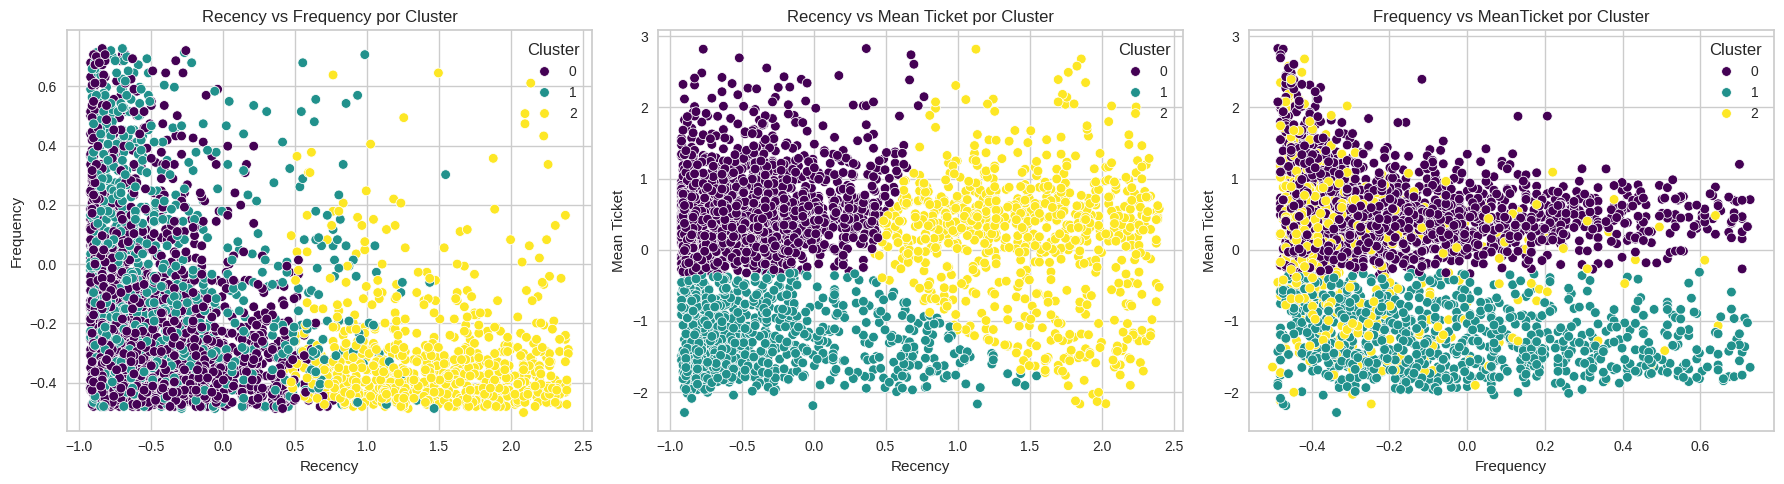

In [ ]:
# Função para plotar clusters em um gráfico de dispersão (scatter plot)
def plot_clusters_side_by_side(df, x1, y1, x2, y2, x3, y3, hue='Cluster',
                               title1='', title2='', title3='',
                               xlabel1='', xlabel2='', xlabel3='',
                               ylabel1='', ylabel2='', ylabel3=''):

    # Cria uma figura com 1 linha e 3 colunas
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 3 gráficos em uma linha

    # Primeiro gráfico: scatter plot para Recency vs Frequency
    sns.scatterplot(data=df, x=x1, y=y1, hue=hue, palette='viridis', ax=axes[0])
    axes[0].set_title(title1)
    axes[0].set_xlabel(xlabel1)
    axes[0].set_ylabel(ylabel1)

    # Segundo gráfico: scatter plot para Recency vs MeanTicket
    sns.scatterplot(data=df, x=x2, y=y2, hue=hue, palette='viridis', ax=axes[1])
    axes[1].set_title(title2)
    axes[1].set_xlabel(xlabel2)
    axes[1].set_ylabel(ylabel2)

    # Terceiro gráfico: scatter plot para Frequency vs MeanTicket
    sns.scatterplot(data=df, x=x3, y=y3, hue=hue, palette='viridis', ax=axes[2])
    axes[2].set_title(title3)
    axes[2].set_xlabel(xlabel3)
    axes[2].set_ylabel(ylabel3)

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Exibe os gráficos
    plt.show()

# Exemplo de uso da função para criar 3 gráficos lado a lado
plot_clusters_side_by_side(df_rfm_transformed,
                           'Recency', 'Frequency', 'Recency', 'MeanTicket', 'Frequency', 'MeanTicket',
                           title1='Recency vs Frequency por Cluster',
                           title2='Recency vs Mean Ticket por Cluster',
                           title3='Frequency vs MeanTicket por Cluster',
                           xlabel1='Recency', xlabel2='Recency', xlabel3='Frequency',
                           ylabel1='Frequency', ylabel2='Mean Ticket', ylabel3='Mean Ticket')

Perfis Reavaliados dos Clientes

- Cluster 0 (Clientes Ativos e Valiosos)

  - Frequência Alta
  - Recência Baixa (Quanto mais baixa a recência mais recentemente foi a última compra)
  - Ticket Médio Positivo
  
    Estes clientes compram frequentemente e recentemente, gastando valores significativos. Eles são altamente valiosos e devem ser priorizados em campanhas de fidelização para manter o engajamento e incentivar compras adicionais.

- Cluster 1 (Clientes Regulares com Baixo Ticket Médio)

  - Frequência Moderada
  - Recência Baixa
  - Ticket Médio Baixo

    Estes clientes compram regularmente, mas gastam menos em média. Eles são bons candidatos para estratégias de aumento de ticket médio, como promoções e ofertas para produtos complementares, visando aumentar o valor de cada compra.

- Cluster 2 (Clientes Desengajados e Irregulares)

  - Frequência Baixa
  - Recência Alta
  - Ticket Médio Variável

    Estes clientes não compram há muito tempo e, quando compram, o valor é bastante variável, geralmente baixo. Estratégias de reengajamento são fundamentais para este grupo, incluindo ofertas agressivas ou programas de recuperação, como descontos personalizados para motivá-los a retornar.

In [ ]:
# Agrupa o DataFrame df_rfm_transformed pela coluna 'Cluster' e calcula a média das colunas numéricas
cluster_mean = df_rfm_transformed.groupby('Cluster').mean()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

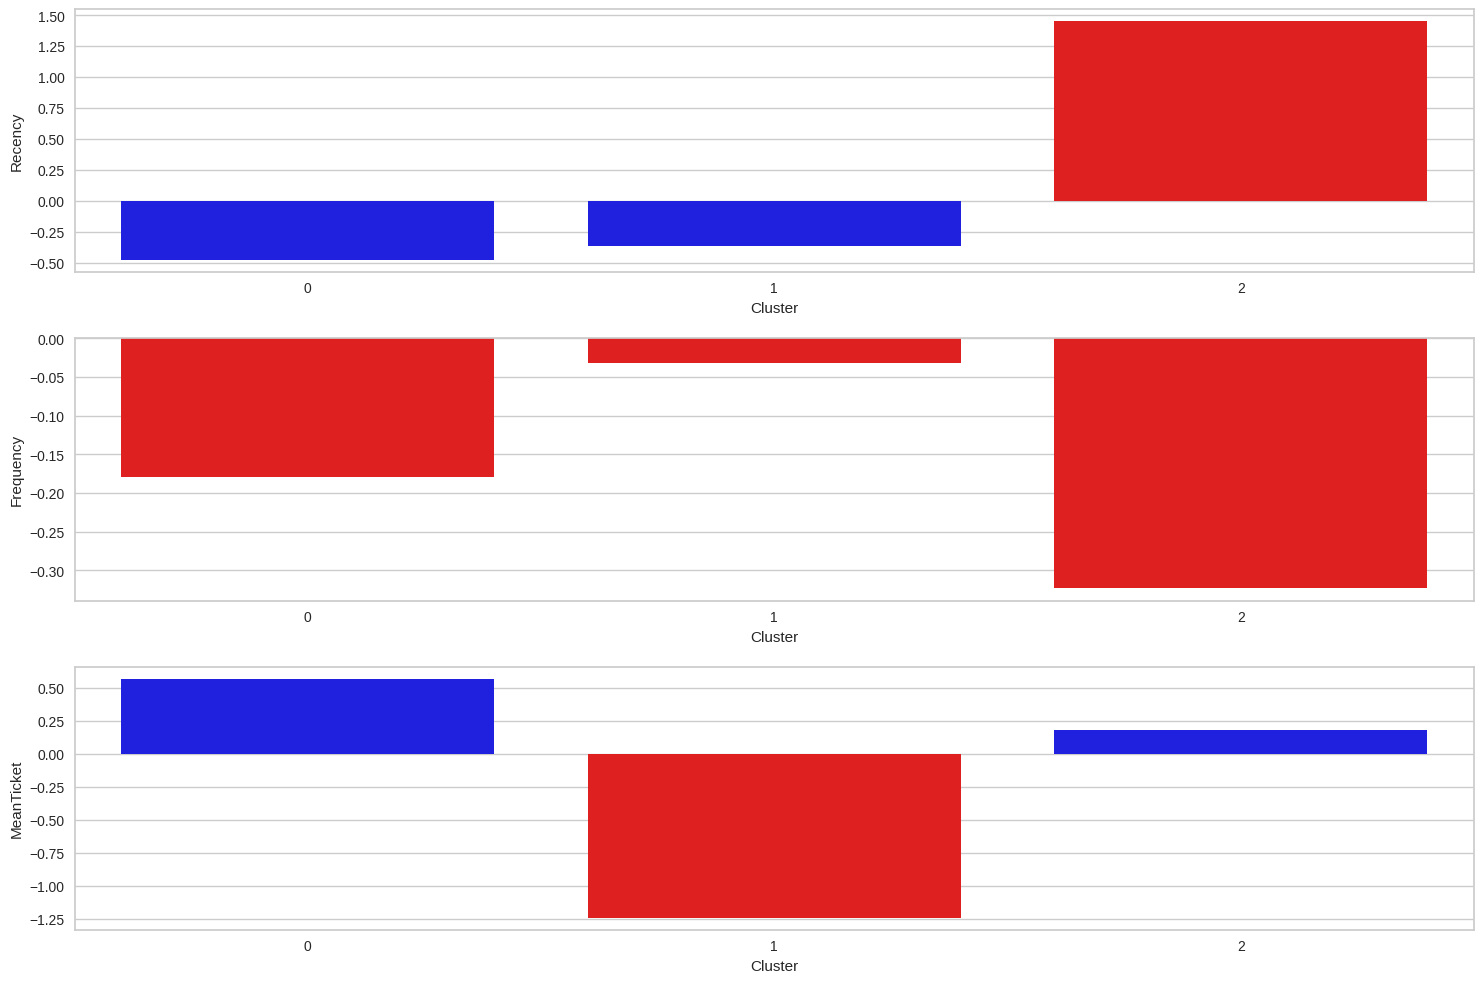

In [ ]:
# Define o tamanho da figura da visualização
plt.figure(figsize=(15, 10))

# Define uma paleta de cores personalizada
palette = ['#00f', '#f00']  # Azul para valores bons e vermelho para valores ruins

# Cria o primeiro gráfico: Barplot de Recency
plt.subplot(3, 1, 1)  # Define um subplot na 1ª posição (1 coluna, 3 linhas, 1ª posição)
sns.barplot(data=cluster_mean, x=cluster_mean.index, y='Recency',
            hue=[0 if value < 0 else 1 for value in cluster_mean['Recency']],  # Define a cor com base no valor da Recency
            palette=palette, legend=False)  # Usa a paleta de cores definida

# Cria o segundo gráfico: Barplot de Frequency
plt.subplot(3, 1, 2)  # Define o segundo subplot na 2ª posição
sns.barplot(data=cluster_mean, x=cluster_mean.index, y='Frequency', color='red', legend=False)  # Plota a média de Frequency em vermelho

# Cria o terceiro gráfico: Barplot de Mean Ticket
plt.subplot(3, 1, 3)  # Define o terceiro subplot na 3ª posição
sns.barplot(data=cluster_mean, x=cluster_mean.index, y='MeanTicket',
            hue=[0 if value > 0 else 1 for value in cluster_mean['MeanTicket']],  # Define a cor com base no valor do Mean Ticket
            palette=palette, legend=False)  # Usa a paleta de cores definida

# Ajusta o layout para evitar sobreposição de gráficos
plt.tight_layout()

# Exibe os gráficos
plt.show()

In [ ]:
# Obtém os rótulos dos clusters a partir do modelo de clustering
clusters = set(model.labels_)
# Lista para armazenar os marcadores de cada cluster no gráfico
cluster_markers = []

# Loop para cada cluster identificado
for cluster in clusters:
    # Filtra os dados do DataFrame para o cluster atual
    cluster_data = df_rfm_transformed[model.labels_ == cluster]

    # Cria um objeto de gráfico 3D para os dados do cluster
    cluster_marker = go.Scatter3d(
        x=cluster_data['Recency'],  # Coordenada X: Recência
        y=cluster_data['Frequency'], # Coordenada Y: Frequência
        z=cluster_data['MeanTicket'],  # Coordenada Z: Valor Monetário
        mode='markers',               # Define o modo de visualização como marcadores
        marker=dict(size=5, line=dict(width=1, color='black')),  # Estilo dos marcadores
        name=f'Cluster {cluster}'     # Nome do cluster para legenda
    )
    # Adiciona o marcador do cluster à lista de marcadores
    cluster_markers.append(cluster_marker)

# Configuração do layout do gráfico
layout = go.Layout(
    title='Scatterplot 3D dos Clusters',  # Título do gráfico
    scene=dict(
        xaxis_title='Recência (R)',         # Título do eixo X
        yaxis_title='Frequência (F)',       # Título do eixo Y
        zaxis_title='Ticket Médio (M)',     # Título do eixo Z
        bgcolor='black',                     # Cor de fundo do espaço 3D
        # Estilização dos eixos
        xaxis=dict(backgroundcolor='black', gridcolor='gray', titlefont=dict(color='white')),
        yaxis=dict(backgroundcolor='black', gridcolor='gray', titlefont=dict(color='white')),
        zaxis=dict(backgroundcolor='black', gridcolor='gray', titlefont=dict(color='white'))
    ),
    paper_bgcolor='black',                # Cor de fundo do papel (todo o gráfico)
    font=dict(color='white')              # Cor da fonte dos textos no gráfico
)

# Criação da figura usando os dados dos marcadores e o layout configurado
fig = go.Figure(data=cluster_markers, layout=layout)

# Exibe o gráfico interativo
fig.show()

# Conclusão final

## Perfil dos clientes

A análise dos dados dos clientes revelou três clusters distintos, cada um com características únicas que influenciam seu comportamento de compra e seu valor para a empresa. Com base nas métricas de Recency, Frequency e Mean Ticket, reclassificamos os perfis dos clientes e definimos estratégias direcionadas para cada grupo.

1. Cluster 0: Clientes Ativos e Valiosos
   - Características: Este grupo é composto por clientes que apresentam alta frequência de compras e baixa recência, com um ticket médio positivo. Esses clientes compram frequentemente e gastam valores significativos, demonstrando um forte engajamento e lealdade à marca.
  
2. Cluster 1: Clientes Regulares com Baixo Ticket Médio
   - Características: Os clientes deste cluster têm frequência de compras moderada, recência baixa e um ticket médio relativamente baixo. Eles compram com regularidade, mas seu gasto não atinge o mesmo patamar dos clientes do Cluster 0.

3. Cluster 2: Clientes Desengajados e Irregulares
   - Características: Com baixa frequência e alta recência, os clientes desse cluster não compram há um bom tempo, e o valor gasto em suas compras é variável, geralmente baixo. Esse comportamento indica um desinteresse ou falta de engajamento com a marca.

A identificação clara desses perfis permitirá à sua empresa desenvolver estratégias de marketing mais focadas e eficazes, otimizando o retorno sobre os investimentos realizados. A análise apresentada não é estática; recomenda-se revisitar esses perfis periodicamente para garantir que as estratégias se adaptem às mudanças nas dinâmicas de compra e nas preferências dos clientes.

## Justifivativa

A análise dos perfis de clientes, baseada em Recency, Frequency e Mean Ticket, é fundamental para a segmentação e personalização das campanhas de marketing da sua empresa. Ao identificar clusters distintos de clientes, a empresa pode direcionar suas estratégias de marketing de forma mais eficiente, criando campanhas personalizadas que atendam às necessidades específicas de cada grupo. Por exemplo, clientes ativos podem receber promoções exclusivas, enquanto clientes desengajados podem ser impactados por campanhas de reengajamento com descontos especiais.

Essa abordagem não só melhora a experiência do cliente, mas também maximiza o retorno sobre o investimento (ROI), alocando recursos de maneira mais eficaz em segmentos com maior potencial de crescimento. Além disso, a análise oferece insights valiosos para o desenvolvimento de produtos e serviços, alinhando-se melhor às expectativas dos clientes. A compreensão dos comportamentos dos clientes permite implementar estratégias focadas na retenção, incentivando frequências de compra mais altas.

Em suma, a análise de perfil de clientes permite uma segmentação mais precisa e campanhas de marketing personalizadas, resultando em marketing mais eficaz, maior satisfação do cliente e aumento no retorno sobre o investimento. Com essa estratégia, sua empresa estará bem posicionada para crescer e se destacar em um mercado competitivo.

## Ações que podem ser tomadas

- Cluster 0: Clientes Ativos e Valiosos
  - Campanhas de Fidelidade: Desenvolver programas de fidelidade que ofereçam recompensas por compras frequentes, como pontos que podem ser trocados por descontos ou produtos exclusivos.
  - Promoções Exclusivas: Criar acesso antecipado a novos lançamentos e promoções especiais para este grupo, incentivando a continuidade das compras.
  - Upselling e Cross-selling: Implementar ofertas de produtos complementares durante o processo de compra, aumentando o valor médio do ticket.

- Cluster 1: Clientes Regulares com Baixo Ticket Médio
  - Bundles de Produtos: Oferecer pacotes promocionais com desconto em itens que costumam ser comprados juntos, aumentando o valor das compras.
  - Campanhas de Reativação: Criar comunicações personalizadas que incentivem a compra de produtos que o cliente já adquiriu anteriormente.
  - Testes A/B: Realizar testes em diferentes tipos de promoções para identificar quais ofertas geram mais engajamento e vendas.

- Cluster 2: Clientes Desengajados e Irregulares
  - Campanhas de Reengajamento: Implementar ações específicas com descontos atrativos e ofertas por tempo limitado, visando recuperar o interesse desses clientes.
  - Pesquisa de Satisfação: Realizar pesquisas para entender as razões do desengajamento e coletar feedback sobre o que poderia melhorar sua experiência.
  - Monitoramento de Atividade: Criar um sistema de alerta que identifique clientes que estão se afastando e ative estratégias de recuperação antes que o desengajamento se torne irreversível.